In [1]:
import pandas as pd
import numpy as np
import processing_pipeline as pp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy import ndimage 
from sklearn.model_selection import train_test_split
import processing_pipeline as pp


DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:matplotlib:matplotlib data path: c:\Users\framo\Google Drive\github\NotHotDog\.conda\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\framo\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\framo\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\framo\.matplotlib\fontlist-v330.json


In [8]:
pipe = pp.preprocess()
df = pipe.rebuild_dataset('../df.h5')

In [10]:
df.shape

(4630, 2)

In [11]:
img = np.stack(df.img)

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

encoder = LabelEncoder().fit(df.label.str.contains("Hot"))
labels = encoder.transform(df.label.str.contains("Hot"))


In [56]:

X_train, X_test, y_train, y_test = train_test_split(
    img, labels, test_size=0.33, random_state=42)


In [13]:
X_train.shape

(3102, 250, 250, 3)

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#we can set the input size to be the size of the input image (not necessarily 224x224)
#VGG19(weights='imagenet', input_shape=[32,32,3],include_top=False) 
base_model = ResNet50(weights='imagenet',input_shape=[250,250,3],include_top=False)

feature_model = Model(inputs= base_model.input, outputs=base_model.output )

train_images_sub = preprocess_input(X_train)
test_images_sub = preprocess_input(X_test)
train_features = feature_model.predict(train_images_sub)
test_features = feature_model.predict(test_images_sub)

48/48 [==============================] - 174s 4s/step


In [58]:
train_features.shape

(3102, 8, 8, 2048)

In [59]:
model4 = keras.Sequential(
    [
        layers.Input((8, 8, 2048)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, activation='softmax')
    ], 
)

opt = keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

cls4=model4.fit(train_features, y_train, validation_data=(test_features, y_test),epochs=30, batch_size=32)

Epoch 1/30
97/97 [==============================] - 70s 654ms/step - loss: 3.2244 - accuracy: 0.6593 - val_loss: 0.6428 - val_accuracy: 0.7788
Epoch 2/30
97/97 [==============================] - 61s 628ms/step - loss: 0.5489 - accuracy: 0.7444 - val_loss: 0.7974 - val_accuracy: 0.7781
Epoch 3/30
97/97 [==============================] - 60s 624ms/step - loss: 0.6773 - accuracy: 0.7202 - val_loss: 0.8217 - val_accuracy: 0.5255
Epoch 4/30
97/97 [==============================] - 62s 637ms/step - loss: 0.4852 - accuracy: 0.7756 - val_loss: 0.4625 - val_accuracy: 0.7912
Epoch 5/30
97/97 [==============================] - 64s 657ms/step - loss: 0.5597 - accuracy: 0.7602 - val_loss: 1.0436 - val_accuracy: 0.7768
Epoch 6/30
97/97 [==============================] - 63s 651ms/step - loss: 0.5725 - accuracy: 0.7605 - val_loss: 0.4557 - val_accuracy: 0.7978
Epoch 7/30
97/97 [==============================] - 63s 654ms/step - loss: 0.4149 - accuracy: 0.8153 - val_loss: 0.4443 - val_accuracy: 0.7958

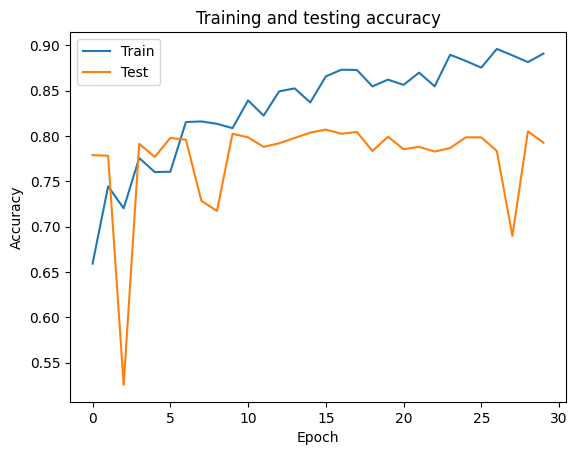

In [60]:
plt.plot(cls4.history['accuracy'], label='Train')
plt.plot(cls4.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

In [63]:
# Majority class only
np.unique(labels, return_counts=True)
3526/(3526+1104)


0.7615550755939525